# Homework 5

Ben Fogarty  
University of Chicago, Harris School of Public Policy  
CAPP 30254: Machine Learning for Public Policy  
Spring 2019

## Project overview and assignments

This project's folder contains the following files:

- writeup.pdf: the explanatory writeup detailed in the assingment
- demonstratrion.ipynb: jupyter notebook demonstrating some of the pipeline's functionality
- pipeline_library.py: general functions for a machine learning pipeline (reading data, preprocessing data, generating features, building models, etc.)
- predict_fudning.py: specific functions for applying the functions in pipeline_library to the DonorsChoose Data  


- output/: text and figure output from running the software with the full dataset  


- configs/features.json: details features parameters to run the models with
- configs/preprocessing.json: details preprocess features to run the models with
- configs/models.json: a full list of models to run
- configs/flipped_models.json: a full list of models to run in reverse order
- configs/mini_models.json: a shorter list of models to run  


- data/projects_2012-2013.csv: the DonorsChoose dataset
- data/projects_1000.csv: a sample of 1000 DonorsChoose projects
- data/projects_sample.csv: a sample of 10000 DonorsChoose projects  


- assignment.md: the assignment statement

The project was developed using Python 3.7.3 on MacOS Mojave 10.14.4. It requires the following libraries:

| Package        | Version     |
| :------------: | :---------: |
| dateutil       | 2.8.0.      |
| graphviz       | 0.8.4       |
| pandas         | 0.24.2      |
| matplotlib     | 3.0.3       |
| numpy          | 1.16.2      |
| seaborn        | 0.9.0       |
| scikit-learn   | 0.20.3      |

Helpful documentation and references are cited throughout the docstrings of the code.

To run the program, use the following command:
```
python3 predict_funding.py -d <path to dataset> -f <path to features config JSON file>
-m <path to models config JSON file> [-p <path to optional preprocessing config file>]
[-s <optional random seed>] [--savefigs (denotes that figures should be saved instead of displayed)]
```

## Document summary

This document provides a brief description of the functions in my machine learning pipeline module, pipeline_librry, that are available for generating, applying, and evaluating machine learning models. It is not an exhaustive list of available functions, as many of these functions have been covered in past homeworks, and it does not cover any of my functions for exploring data.

In [41]:
import pandas as pd
import pipeline_library as pl
import predict_funding as pf

## Preprocessing

The preprocessing function, preprocess_data, now supports four types of imputation: mean, median, mode, and manual, and uses can specify which method to use for each column in a given dataset. If the imputation method is not specified, then by default median is used to impute numeric columns, and mode is used to impute categorical columns. Furthermore, the preprocess data function also adds a new column to the dataframe for every column it process that denotes whether a value had to be imputed for that column. This new column has the name "<original col name>_missing". Below is an example of this function applied to a toy dataset.

In [42]:
df = pd.DataFrame({'species': ['dog', 'cat', 'pig', 'dog', 'mouse'],
                   'age': [1, 3, 9, 4, float('nan')],
                   'name': ['Lance', 'Barry', None, 'Barry', 'Tom']})
df

,species,age,name
0,dog,1.0,Lance
1,cat,3.0,Barry
2,pig,9.0,None
3,dog,4.0,Barry
4,mouse,NaN,Tom


In [43]:
pl.preprocess_data(df)

,species,age,name,species_missing,age_missing,name_missing
0,dog,1.0,Lance,False,False,False
1,cat,3.0,Barry,False,False,False
2,pig,9.0,Barry,False,False,True
3,dog,4.0,Barry,False,False,False
4,mouse,3.5,Tom,False,True,False


In [44]:
pl.preprocess_data(df,
                   methods={'age': 'mean',
                            'name': 'manual'},
                   manual_vals={'name': 'MISSING'})

,species,age,name,species_missing,age_missing,name_missing
0,dog,1.00,Lance,False,False,False
1,cat,3.00,Barry,False,False,False
2,pig,9.00,MISSING,False,False,True
3,dog,4.00,Barry,False,False,False
4,mouse,4.25,Tom,False,True,False


## Feature generation

The availabe suite of functions to generate features with remains largely unchanged from previous interations of my pipeline. However, all the feature generation functions have been adapted to handle the need to generate features for training and testing data separately. As a result, the precise code and interface of some of the functions may vary from previous homeworks.

There are thre new feature generation functions: cut_binary, generate_n_ocurrences, and scale_variable_minmax. The first, cut_binary, can be used cut a varaible into true and false variables based on some threshold. Returning to the toy dataset, we could use it to find all animals more than 5 years old as follows.

In [45]:
pl.cut_binary(df.age, 5, or_equal_to=False)

0    False
1    False
2     True
3    False
4    False
Name: age, dtype: bool

The generate_n_occurences functions links each observation in a series with how many times its value appears in the dataset. For example, if we wanted to generate a feature based on how common each animal's species is, we could do the following.

In [46]:
pl.generate_n_occurences(df.species)

0    2
1    1
2    1
3    2
4    1
Name: species, dtype: int64

Notice that the values at index locations 0 and 3 are 2 because there are two dogs in the dataset.

Finally, scale_variable_minmax rescales a numerical variable. Without any additional parameters, the maximum values of the column is made equal to 1, the minimum value is made equal to -1, and all other values are scaled proportionally. Alternatively, the user can specify what values should be scaled to 1 and -1. Applying this to the age column of the toy dataset from before.

In [47]:
pl.scale_variable_minmax(df.age)

0   -1.00
1   -0.50
2    1.00
3   -0.25
4     NaN
Name: age, dtype: float64

## Temporal splitting

For the next sections, we'll need some real data, so we will load in a sample of the Donors' Choose data set and generate some features in the next few lines.

In [48]:
dataset_fp, preprocess_specs, feature_specs,\
model_specs, seed, save_figs = pf.parse_args({'dataset': 'projects_1000.csv',
                                             'preprocess': 'preprocessing.json',
                                             'features': 'features.json',
                                             'models': 'models.json',
                                             'seed': 11012017,
                                             'save_figs': False})
col_types = {'projectid': str,
             'teacher_acctid': str,
             'schoolid': str,
             'school_ncesid': str,
             'school_latitude': float,
             'school_longitude': float,
             'school_city': str,
             'school_state': str,
             'school_metro': str,
             'school_district': str,
             'school_county': str,
             'school_charter': str,
             'school_magnet': str,
             'teacher_prefix': str,
             'primary_focus_subject': str,
             'primary_focus_area': str,
             'secondary_focus_subject': str,
             'secondary_focus_area': str,
             'resource_type': str,
             'poverty_level': str,
             'grade_level': str,
             'total_price_including_optional_support': float,
             'students_reached': float,
             'eligible_double_your_impact_match': str,
             'date_posted': str,
             'datefullyfunded': str}
df = pl.read_csv(dataset_fp, col_types=col_types, index_col='projectid')
df = pf.transform_data(df)
df

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,school_county,...,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,daystofullfunding,not_fully_funded_60days
projectid,,,,,,,,,,,,,,,,,,,,,
e8df93b249207fa13f425a7ce72bef88,5c3df555fd3e4e0f8589f415d2689367,0c2abf08a5cf9968a3027b57159e3464,273384000000,44.952595,-93.134918,Saint Paul,MN,urban,St Paul Independent SD 625,Ramsey,...,Supplies,highest poverty,Grades PreK-2,515.78,75.0,0.0,2013-03-10,2013-05-28,79,True
d1aa2d0f129c0d9ee6689283235a9439,af639be63ab70090b959a4239b98dc67,4971d231b90770f86b0328f4656f5b53,270606000000,45.716742,-93.179303,Braham,MN,rural,Braham Ind School District 314,Isanti,...,Other,high poverty,Grades PreK-2,595.34,24.0,0.0,2013-06-26,2013-08-19,54,False
055d36357fba559c6a628bda8eda96ac,f26747e5bf3ba27ffc8dc69a0bbf5178,9f3a2ef9ff09b853477a44666594a142,370003000000,36.217233,-79.307794,Burlington,NC,NaN,Alamance-burlington Sch Dist,Alamance,...,Books,highest poverty,Grades PreK-2,333.96,200.0,0.0,2013-11-13,2013-12-19,36,False
e9354510e4d1128a6f70662a95022a46,54da1eb34f18c5e3dba437b06e137cf3,e6c2b51eae39b8d07ae00911347bc614,20000100474,60.708656,-163.100662,Nightmute,AK,rural,Lower Kuskokwim School Dist,Bethel,...,Technology,high poverty,Grades 6-8,316.87,20.0,0.0,2012-04-15,2012-06-08,54,False
dc0bf288d3b322a32aadbe7b7dfc3c1c,55d0ef48f5e18a010256c338117eb0d9,6c14f9cabdb6ab825c67c7db8b64777a,62271002960,33.764924,-118.316505,Rch Palos Vrd,CA,suburban,Los Angeles Unif Sch Dist,Los Angeles,...,Other,high poverty,Grades 6-8,931.06,999.0,1.0,2012-02-01,2012-03-08,36,False
12807968b7f259ccb3f481f1150daf82,dc8daf4046ac85e85b06e58d434256f1,d5e1ccff2e9792cd5c9f345a73b9430f,80336000336,39.672916,-105.044776,Denver,CO,urban,Denver Public School Dist 1,Denver,...,Books,highest poverty,Grades PreK-2,375.49,16.0,0.0,2013-05-28,2013-06-16,19,False
c952166294f9d37e3867da855ca7b20d,7f9834a49b560f768a4839a3bbb09cce,893b6748c2dc78147707736b9b6d6137,130090000000,34.151049,-84.814390,Cartersville,GA,NaN,Cartersville City Schools,Bartow,...,Supplies,high poverty,Grades 3-5,275.51,44.0,1.0,2013-11-03,2013-12-26,53,False
7e7f37d51d2cf579d4b45eac8cde7cf6,0691c15093024a68f8fb0f77e7890945,f7e1b815c774766d09fa06c41f962c0d,370297000000,35.255314,-80.897646,Charlotte,NC,urban,Charlotte-mecklenburg Sch Dist,Mecklenburg,...,Books,highest poverty,Grades 6-8,907.60,25.0,0.0,2013-02-21,2013-03-07,14,False
513d9cea785dbf755ea6c2e4117cf990,8f93d887ec4bef45b1831640dc17cc7f,6e3b1c77927203ccc4d3facc2aa32e36,80192001905,39.027639,-104.797980,Colorado Spgs,CO,rural,Academy School District 20,El Paso,...,Supplies,low poverty,Grades PreK-2,504.59,40.0,0.0,2013-11-10,2013-11-16,6,False


## Temporal splits

The pipeline now contains a function, create_temporal_test_splits, that can divide a datset into training and test splits based on time intervals. The function requires three parameters, a dataframe, the name of the date column to split on, and the time length to include in each split. Optionally, the function may also take a gap parameter that specifies how much of a time gap to leave between training and testing set and a start date specifying the first date to include in a testing split. We can apply this function to the sample from above to create three training/test sets with a split length of 6 months and a gap of sixty days.

In [49]:
training, testing = pl.create_temporal_splits(df, 'date_posted',
                                           {'months': 6}, 
                                           gap={'days': 60})
max(training[0].date_posted)

Timestamp('2012-05-01 00:00:00')

In [50]:
min(testing[0].date_posted)

Timestamp('2012-07-02 00:00:00')

Next, we preprocess the dataset and geneate features to enable discussing model generation, prediction, and evaluation.

In [51]:
for i in range(len(training)):
    training[i] = pf.preprocess_data(training[i], **preprocess_specs)
    testing[i] = pf.preprocess_data(testing[i], **preprocess_specs)
    training[i], testing[i] = pf.generate_features(training[i],
                                                   testing[i],
                                                   **feature_specs)

## Generating models

In my machine learning pipeline, model generation is designed around dictionaries with model specifications in them. In particular, the generate_classifier function takes in three arguments: feature variable values, target variable values, and a dictionary of model specifications. The dictionary of model specifications must contain a key titled "model" that specifies the type of model to generate, and currently supported values on this parameter include:  

- 'dt': sklearn.tree.DecisionTreeClassifier
- 'lr': sklearn.linear_model.LogisticRegression
- 'knn': sklearn.neighbors.KNeighborsClassifier
- 'svc': sklearn.svm.LinearSVC
- 'rf': sklearn.ensemble.RandomForestClassifier
- 'boosting': sklearn.ensemble.AdaBoostClassifier
- 'bagging': sklearn.ensemble.BaggingClassifier
- 'dummy': sklearn.dummy.DummyClassifier

The dictionary may contain an optional key titled "name" that is used to help identify the model in figures and print statements. All other key-value pairs in the entires should be parameters for the specified classifer and values to be passed as that parameter. For example, we will use the following dictionary to generate a decision tree classifier that uses information gain to split and has a maximum depth of 10 levels with our first temporal training set.

In [52]:
dt_max_dept_10 = {'model': 'dt',
                  'criterion': 'entropy',
                  'max_depth': 10}
features = training[0].drop('not_fully_funded_60days', axis=1)
target = training[0].not_fully_funded_60days
dt = pl.generate_classifier(features, target, dt_max_dept_10)
dt

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Furthermore, there is also a function to programatically generate valid model specification dictionaries while iterating over one parameter of a model. This function, generate_iter_model_specs, take a base specification dictionary, the name of a parameter to iterate over, and an iterable of parameter values as arguments, and produces a list of model specification dictionaries. To generate decision tree model specifications split on entropy with max depths of 5, 10, 15, 20, 25, and 30, we could run the following:

In [53]:
dt_specs = pl.generate_iter_model_specs({'model': 'dt', 'criterion': 'entropy'},
                             'max_depth', range(5, 35, 5))
dt_specs

[{'model': 'dt', 'criterion': 'entropy', 'max_depth': 5},
 {'model': 'dt', 'criterion': 'entropy', 'max_depth': 10},
 {'model': 'dt', 'criterion': 'entropy', 'max_depth': 15},
 {'model': 'dt', 'criterion': 'entropy', 'max_depth': 20},
 {'model': 'dt', 'criterion': 'entropy', 'max_depth': 25},
 {'model': 'dt', 'criterion': 'entropy', 'max_depth': 30}]

We could use this dictionary in a for loop to create different decision tree models on the above sample.

In [54]:
dt_models = []
for specs in dt_specs:
    dt_models.append(pl.generate_classifier(features, target, specs))
dt_models

[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=15,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_le

Finally, there is also a function, write_model_specs, that will write a list of model specifications to a file in JSON format so that they can be used as a command line argument later. For example, we could write the above list of decision tree model specifications to the file "dt_models.json".

In [55]:
pl.write_model_specs(dt_specs, 'dt_models.json')

## Prediction functions

There are two functions for generating predictoins from a model. The first, predict_target_probability, takes a trained sklearn classifier and a set of feature values as arguments and returns a pandas series of predicted probabilites/scores for each observation in the features dataset. Applying this to the exemplar decision tree and the first training set we built above:

In [56]:
features = testing[0].drop('not_fully_funded_60days', axis=1)
pred_probs = pl.predict_target_probability(dt, features)
pred_probs

projectid
edeae3837263d4416ae3500b1c13c8c8    0.000
15c614bbc35ea63143bf555747e53f53    1.000
cfe90460a7c4703e0eddb187428de155    0.000
d04003d48135a623f89fe29477cc9594    0.000
753245d49987cc84f0c332ea84ab0cf9    1.000
1953c053f05595f9007ff2cec792f94a    0.000
3c4263ef73b2a5a33a57c3932ec152b5    0.000
50a959e7786e36ce47a5f27cdbf717aa    0.000
b5c19a74e00a2d192ce966b2f76f7995    0.000
fc06a589d721a9b9f99583849028b768    1.000
e138bbc382d5f6899a357473be7d50fe    0.000
1dd8317fb0157157b83811ee687a648f    1.000
ab7369b862237cb14ff23a25e1683432    1.000
eed1fd500439f1ac24cf6b1a93710114    0.000
c0fe62218ee8495ae6224596d3e5a38b    0.000
424372cf8a56c247bf6ddd69b1e72b4c    0.000
116b75d89b5a81ef07c633569fb8169f    0.000
e00f0256574d8ca41d3d30c906347f7a    1.000
db853f029e00569b67c81f164caa80b5    1.000
c6f62088da37f9ff4260cfff552dc4e6    1.000
3f88b85cb96fdd7989cd4e1ce9b56916    0.000
595ef4810b6e1414c61c1190debc7cb6    0.000
431602da1901f8527c480f62d11d00f5    0.000
7a94688ec698da658f9e7932

The second, predict_target_class, requires a set of predicted probabilies (like those generated by predict_target_probability) and a threshold quantile in the range [0, 1], and can optionally take a parameter specifying the tiebreaker, the true classes of year observation, and a random seed. This function will report all observations with a predicted probability in the specified percentile or above as a true/positive, and all others as a false/negative. In the case where there is a tie at the quantile threshold (for example, if .25 of the dataset has a predicted probabily at or above the .8 quantile), then there are three tie breaker options: random, pessimistic, and optimistic. 

Random tiebreaking randomly selects which instance at the threshold to classify as postivie and which to classify as negative. Pessimistic tiebreaking marks the maximum number of instances at the threshold that are actually negative as positive/true, the randomly selects other instances at the threshold to mark as positive/true as needed. This method represents a worst case estimate on how random tiebreaking can perfrom. Optimistic tiebreaking marks the maximum number of instances at the threshold that are actually positive as positive/true, the randomly selects other instances at the threshold to mark as positive/true as needed. This method represents a best-case estimate on how random tiebreaking can perfrom. If optimistic or pessimistic tiebreaking is selected, the actual values of the target value for each instance must be provided as an argument to the function, but this is not necessary for random tiebreaking. By default, random tiebreaking is selected.

As an example, we will apply the random tiebreaking method to the predicted probabilities from our decision tree created above with a threshold of 0.5.

In [57]:
pl.predict_target_class(pred_probs, .5)

projectid
edeae3837263d4416ae3500b1c13c8c8     True
15c614bbc35ea63143bf555747e53f53     True
cfe90460a7c4703e0eddb187428de155    False
d04003d48135a623f89fe29477cc9594    False
753245d49987cc84f0c332ea84ab0cf9     True
1953c053f05595f9007ff2cec792f94a     True
3c4263ef73b2a5a33a57c3932ec152b5     True
50a959e7786e36ce47a5f27cdbf717aa    False
b5c19a74e00a2d192ce966b2f76f7995    False
fc06a589d721a9b9f99583849028b768     True
e138bbc382d5f6899a357473be7d50fe    False
1dd8317fb0157157b83811ee687a648f     True
ab7369b862237cb14ff23a25e1683432     True
eed1fd500439f1ac24cf6b1a93710114    False
c0fe62218ee8495ae6224596d3e5a38b    False
424372cf8a56c247bf6ddd69b1e72b4c    False
116b75d89b5a81ef07c633569fb8169f    False
e00f0256574d8ca41d3d30c906347f7a     True
db853f029e00569b67c81f164caa80b5     True
c6f62088da37f9ff4260cfff552dc4e6     True
3f88b85cb96fdd7989cd4e1ce9b56916    False
595ef4810b6e1414c61c1190debc7cb6     True
431602da1901f8527c480f62d11d00f5    False
7a94688ec698da658f9e7932

## Evaluating classifiers

To evaluate a classifier, the pipeline_library module contains the evaulate_classifier function, which calculates acuracy, precision, recall, F1, and AUC-ROC metrics and produces a graph of the precision and recall curves for a classifier. This function requires a set of predicted probabilies generate by a model, the true classes of the instances those predicted probabilities were generate for, and a list of floats defining the thresholds to evaluate accuracy, precision, recall, and F1 metrics at. Optionally, the function also accepts arguments about what tiebreaking method to use when prediction classes, a random seed, a model name and dataset name to include in the title of the precision/recall curves graph.

We now apply this function to the predicted probabilites from our decision tree above using random tiebreaking.

(Metric     Threshold
 Accuracy   0.01         0.776471
            0.02         0.764706
            0.05         0.784314
            0.10         0.741176
            0.20         0.694118
            0.30         0.650980
            0.40         0.588235
            0.50         0.545098
 Precision  0.01         0.500000
            0.02         0.200000
            0.05         0.583333
            0.10         0.320000
            0.20         0.294118
            0.30         0.289474
            0.40         0.264706
            0.50         0.267717
 Recall     0.01         0.017544
            0.02         0.017544
            0.05         0.122807
            0.10         0.140351
            0.20         0.263158
            0.30         0.385965
            0.40         0.473684
            0.50         0.596491
 F1         0.01         0.033898
            0.02         0.032258
            0.05         0.202899
            0.10         0.195122
            0.20         0

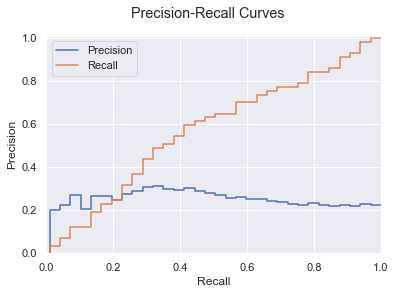

In [58]:
true_classes = testing[0].not_fully_funded_60days
pl.evaluate_classifier(pred_probs, true_classes, [0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50])